In [1]:
import jax
from jax import numpy as jnp
from jax import jit, grad, vmap, random, value_and_grad
import numpy as np
import matplotlib.pyplot as plt
from jax.nn import initializers as ini
import optax

In [2]:
def x_uni(n, lb, ub):
    x = jnp.linspace(lb, ub, n, dtype=np.float32)
    return x

def f3(x):
    x = np.array(x)
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < 0:
            j = 0
            y[i] = 5
            for j in range(5):
                y[i] += np.sin((j+1)*x[i])
        if x[i] >= 0:
            y[i] = np.cos(10*x[i])
    noise = np.random.normal(0, 0.1, len(y))
    y += noise
    y = jnp.array(y)
    return y

In [3]:
def he_norm(m, n, random_key, scale=0.01):
    w_key, b_key = random.split(random_key)
    weights = 1/(jnp.sqrt(m+n)) * random.normal(w_key, (n, m))
    # weights = ini.he_normal(w_key, (n, m))
    biases = jnp.zeros((n,)) 
    # print(weights)
    return weights, biases

def he_uni(m, n, random_key, scale=0.01):
    w_key, b_key = random.split(random_key)
    weights = random.uniform(w_key, shape = (n,m), minval = -jnp.sqrt(6/m), maxval = jnp.sqrt(6/m))
    # weights = weights.reshape((n,m))
    # print(weights)
    biases = jnp.zeros((n,)) 
    return weights, biases

def glo_norm(m, n, random_key, scale=0.01):
    w_key, b_key = random.split(random_key)
    weights = jnp.sqrt(2/(m+n)) * random.normal(w_key, (n, m))
    # print(weights)
    biases = jnp.zeros((n,)) 
    return weights, biases

def glo_uni(m, n, random_key, scale=0.01):
    w_key, b_key = random.split(random_key)
    weights =  random.uniform(w_key, shape = (n,m), minval = -jnp.sqrt(6/(m+n)), maxval = jnp.sqrt(6/(m+n)))
    # print(weights)
    # weights = weights.reshape((n,m))
    biases = jnp.zeros((n,)) 
    return weights, biases

In [16]:
def get_init_network_params(sizes, ran_key, initializer):
    keys = random.split(ran_key, len(sizes))
    
    if initializer == 0:
        return [he_norm(m, n, k) \
                for m, n, k in zip(sizes[:-1], sizes[1:], keys)]
    
    if initializer == 1:
        return [he_uni(m, n, k) \
                for m, n, k in zip(sizes[:-1], sizes[1:], keys)]
    
    if initializer == 2:
        return [glo_norm(m, n, k) \
                for m, n, k in zip(sizes[:-1], sizes[1:], keys)]
    
    if initializer == 3:
        return [glo_uni(m, n, k) \
                for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

    
## manually changed activation function
def feedforward_prediction(params, x):     
    for w, b in params[:-1]:
        outputs = jnp.dot(w, x) + b  
        x = jax.nn.relu(outputs)
        # x = jax.nn.sigmoid(outputs)
        # x = jnp.tanh(outputs)
    w_final, b_final = params[-1] 
    final_outputs = jnp.dot(w_final, x) + b_final 
    return final_outputs  

batched_prediction = vmap(feedforward_prediction, in_axes=(None, 0))

@jit
def mse_loss(params, x, y):
    preds = batched_prediction(params, x)
    diff = preds - y
    return jnp.sum(diff*diff)/preds.shape[0]

@jit
def update(params, x, y, learning_rate):
    l, grads = value_and_grad(mse_loss)(params, x, y)
    return [(w - learning_rate * dw, b - learning_rate * db) 
            for (w, b), (dw, db) in zip(params, grads)], l

In [5]:
SEED = 1234
key = random.PRNGKey(SEED)
lr = 1e-02

num_features = 1
num_batches = 80

ran_key, func_key = random.split(key)

x_train = x_uni(num_batches, -np.pi, np.pi)
x_train = x_train.reshape((num_batches, num_features))
y_train = f3(x_train)
y_train = y_train.reshape((num_batches, num_features))

train_batch = 1000

x_pred = x_uni(train_batch, -np.pi, np.pi)
x_pred = x_pred.reshape((train_batch, num_features))
y_test = f3(x_pred)
y_test = y_test.reshape((train_batch, num_features))

In [6]:
# def L2_Error(y, y_pred):
#     f2norm = jnp.linalg.norm(y, ord=2)
#     n_f_norm = jnp.linalg.norm(y_pred - y, ord=2)
#     error = n_f_norm/f2norm
#     return error

In [7]:
Niter = 10000

In [8]:
loss_train_hn = np.zeros(Niter+1)    #he norm train loss
loss_train_hu = np.zeros(Niter+1)    #he uni train loss
loss_train_gn = np.zeros(Niter+1)    #glo norm train loss
loss_train_gu = np.zeros(Niter+1)    #glo uni train loss

In [9]:
# loss_test_hn = np.zeros(Niter+1)    #he norm train loss
# loss_test_hu = np.zeros(Niter+1)    #he uni train loss
# loss_test_gn = np.zeros(Niter+1)    #glo norm train loss
# loss_test_gu = np.zeros(Niter+1)    #glo uni train loss

Tanh Activation

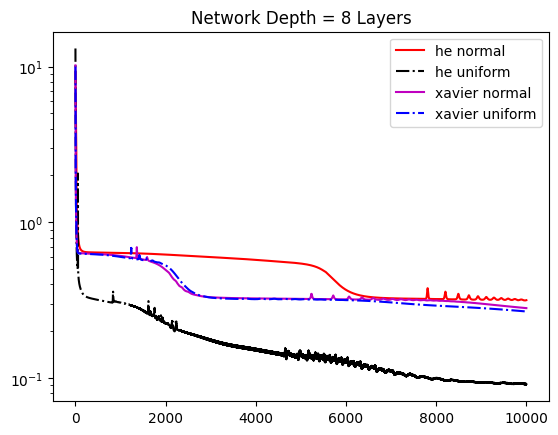

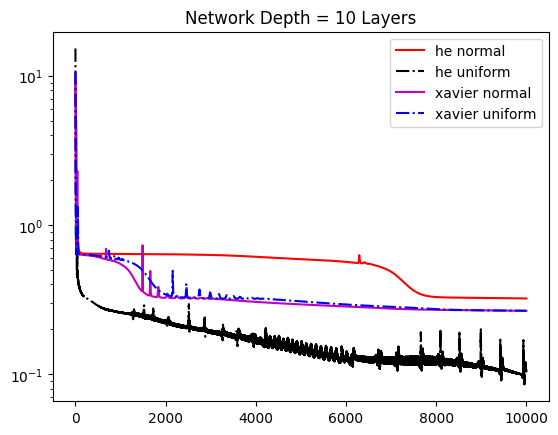

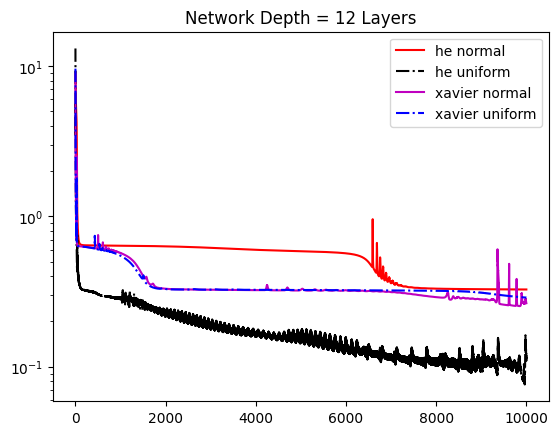

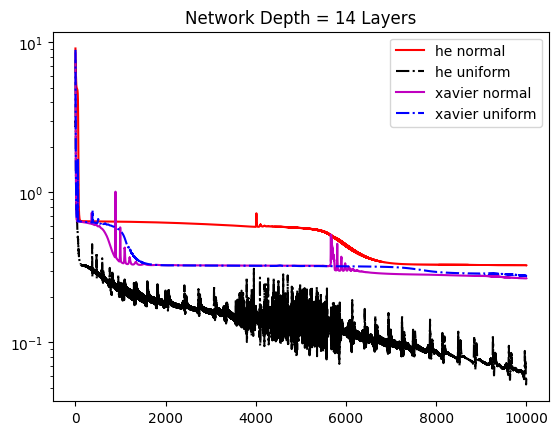

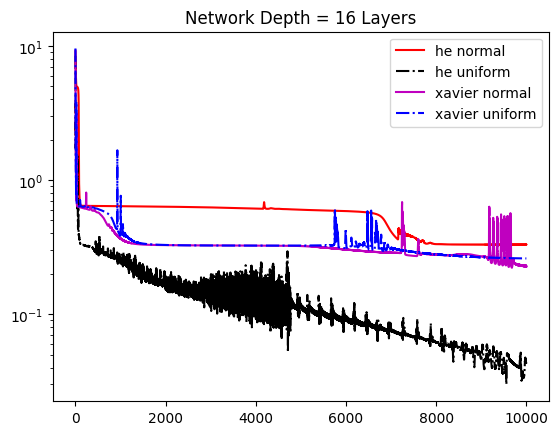

In [15]:
# manually change activation function in feed_forward_prediction()

g = 0

for k in range(8,16+1, 2):
    layers = [1] + [32]*k + [1]
    params_he_norm = get_init_network_params(layers, ran_key, initializer = 0)
    params_he_uni = get_init_network_params(layers, ran_key, initializer = 1)
    params_glo_norm = get_init_network_params(layers, ran_key, initializer = 2)
    params_glo_uni = get_init_network_params(layers, ran_key, initializer = 3)
    
    for i in range(Niter+1):
        params_he_norm, loss_hn = update(params_he_norm, x_train, y_train, lr)   
        loss_train_hn[i] = loss_hn
        
        params_he_uni, loss_hu = update(params_he_uni, x_train, y_train, lr)   
        loss_train_hu[i] = loss_hu
        
        params_glo_norm, loss_gn = update(params_glo_norm, x_train, y_train, lr)   
        loss_train_gn[i] = loss_gn
        
        params_glo_uni, loss_gu = update(params_glo_uni, x_train, y_train, lr)   
        loss_train_gu[i] = loss_gu
    
    plt.figure(g)
    plt.plot(loss_train_hn, 'r-', label = "he normal")
    plt.plot(loss_train_hu, 'k-.', label = "he uniform")
    plt.plot(loss_train_gn, 'm-', label = "xavier normal")
    plt.plot(loss_train_gu, 'b-.', label = "xavier uniform")
    plt.yscale('log')
    # plt.ylim(1e-4, 1e4)
    plt.legend()
    plt.title("Network Depth = " + str(k) + " Layers")
    plt.show()
    g += 1

Sigmoid Activation

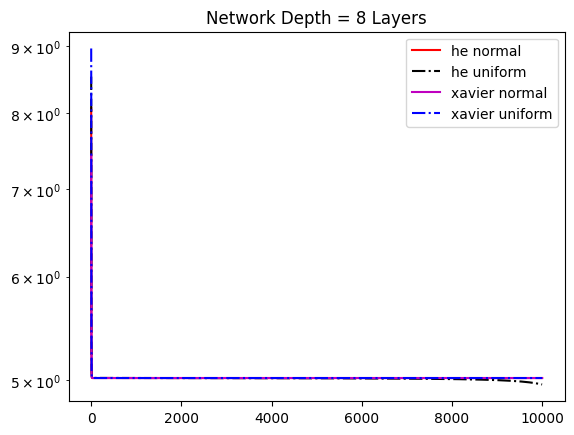

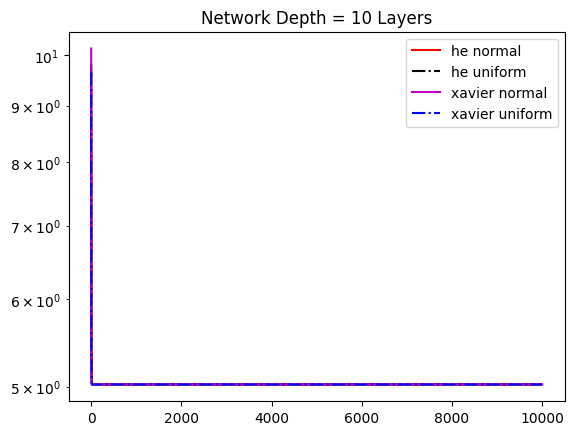

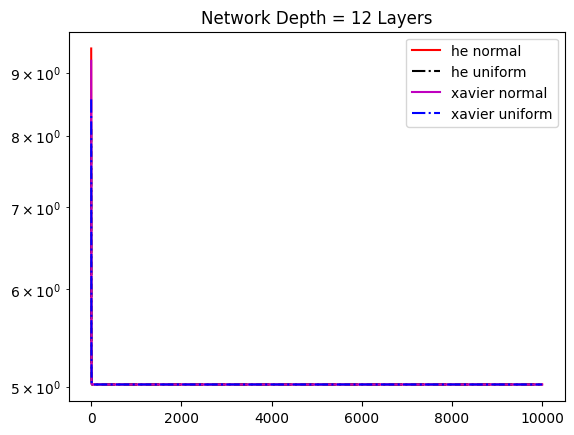

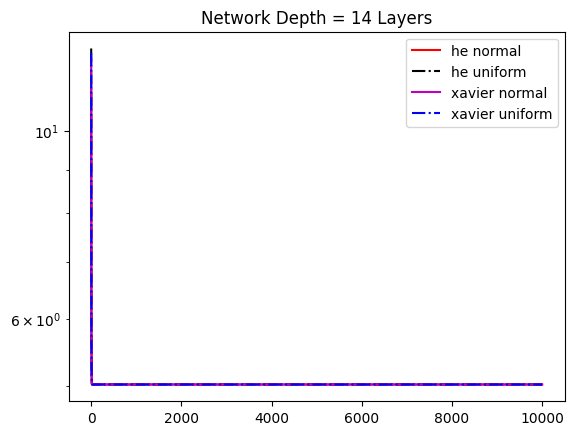

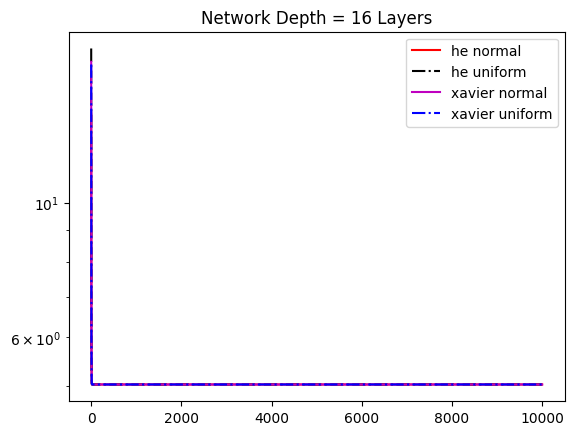

In [13]:
# manually change activation function in feed_forward_prediction()

g = 0

for k in range(8,16+1, 2):
    layers = [1] + [32]*k + [1]
    params_he_norm = get_init_network_params(layers, ran_key, initializer = 0)
    params_he_uni = get_init_network_params(layers, ran_key, initializer = 1)
    params_glo_norm = get_init_network_params(layers, ran_key, initializer = 2)
    params_glo_uni = get_init_network_params(layers, ran_key, initializer = 3)
    
    for i in range(Niter+1):
        params_he_norm, loss_hn = update(params_he_norm, x_train, y_train, lr)   
        loss_train_hn[i] = loss_hn
        
        params_he_uni, loss_hu = update(params_he_uni, x_train, y_train, lr)   
        loss_train_hu[i] = loss_hu
        
        params_glo_norm, loss_gn = update(params_glo_norm, x_train, y_train, lr)   
        loss_train_gn[i] = loss_gn
        
        params_glo_uni, loss_gu = update(params_glo_uni, x_train, y_train, lr)   
        loss_train_gu[i] = loss_gu
    
    plt.figure(g)
    plt.plot(loss_train_hn, 'r-', label = "he normal")
    plt.plot(loss_train_hu, 'k-.', label = "he uniform")
    plt.plot(loss_train_gn, 'm-', label = "xavier normal")
    plt.plot(loss_train_gu, 'b-.', label = "xavier uniform")
    plt.yscale('log')
    # plt.ylim(1e-4, 1e4)
    plt.legend()
    plt.title("Network Depth = " + str(k) + " Layers")
    plt.show()
    g += 1

ReLU Activation

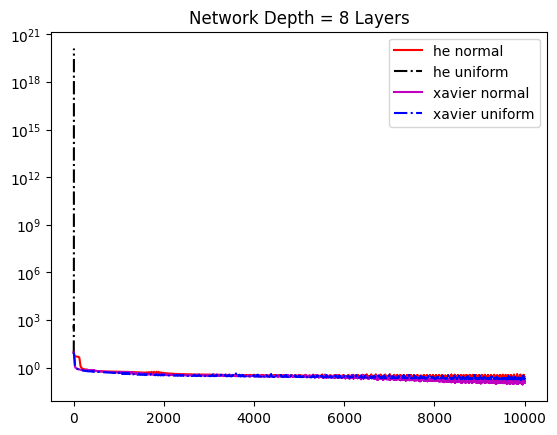

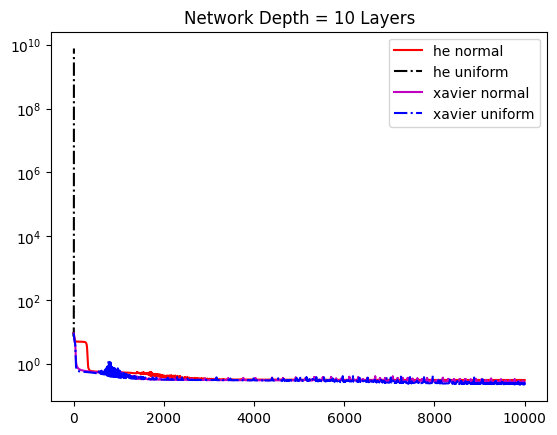

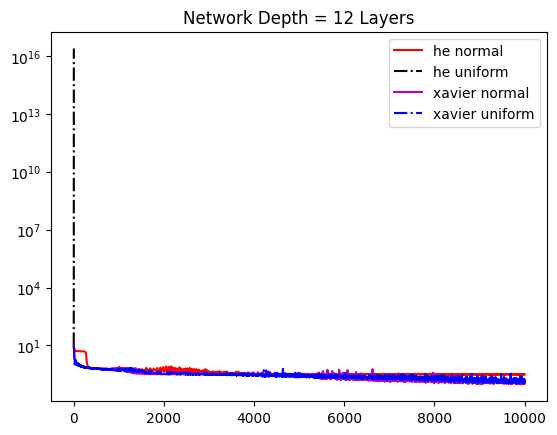

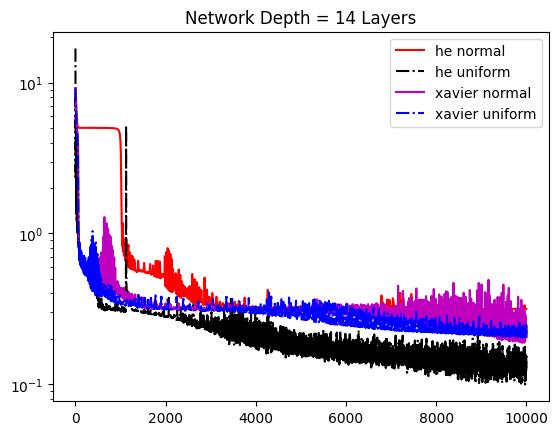

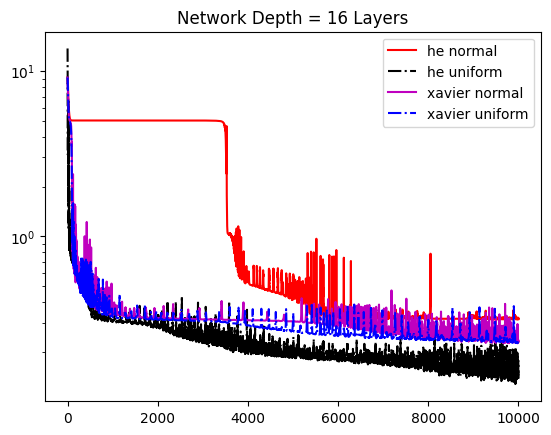

In [17]:
# manually change activation function in feed_forward_prediction()

g = 0

for k in range(8,16+1, 2):
    layers = [1] + [32]*k + [1]
    params_he_norm = get_init_network_params(layers, ran_key, initializer = 0)
    params_he_uni = get_init_network_params(layers, ran_key, initializer = 1)
    params_glo_norm = get_init_network_params(layers, ran_key, initializer = 2)
    params_glo_uni = get_init_network_params(layers, ran_key, initializer = 3)
    
    for i in range(Niter+1):
        params_he_norm, loss_hn = update(params_he_norm, x_train, y_train, lr)   
        loss_train_hn[i] = loss_hn
        
        params_he_uni, loss_hu = update(params_he_uni, x_train, y_train, lr)   
        loss_train_hu[i] = loss_hu
        
        params_glo_norm, loss_gn = update(params_glo_norm, x_train, y_train, lr)   
        loss_train_gn[i] = loss_gn
        
        params_glo_uni, loss_gu = update(params_glo_uni, x_train, y_train, lr)   
        loss_train_gu[i] = loss_gu
    
    plt.figure(g)
    plt.plot(loss_train_hn, 'r-', label = "he normal")
    plt.plot(loss_train_hu, 'k-.', label = "he uniform")
    plt.plot(loss_train_gn, 'm-', label = "xavier normal")
    plt.plot(loss_train_gu, 'b-.', label = "xavier uniform")
    plt.yscale('log')
    # plt.ylim(1e-4, 1e4)
    plt.legend()
    plt.title("Network Depth = " + str(k) + " Layers")
    plt.show()
    g += 1

Because the layer depth was large, I chose a wider network of 32 neurons per layer (esp prevent collapse with ReLU). 10000 training epochs were used for all.

* With tanh activation, there was little to no difference between the training loss for normal and uniform Xavier activations, which displayed a plateau, before dropping and then slowly decaying. They both outperformed the He normal activation, which had a similar plateau, drop, and slow decay profile. He uniform activation outperformed all, which had a much steeper training loss decrease. There seems to be little to no difference between the all the different layer depths, except that as the layers increased, the intermittent spikes in training loss increased in frequency and magnitude, generally.

* When sigmoid activation function was used, there was little to no difference between the training loss of any of the initilizers or layer depths. The training loss quickly settled to approximately 5e0.  

* With ReLU activation, the training error for He Uniform activation skyrocketed for all layer depths, except layers = 14, where it performed better than all the other initializers. However in general, the Xavier initializers were approximately equal, and outperformed the He initializers. The He normal initializer had a training loss higher plateau than the Xavier initializers, and then after some epochs the loss (He normal) dropped down to be slightly above them (Xavier). As the layers increased, the spikes in training loss generally increased both in magnitude and frequency.

